# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [112]:
!pip3 -qq install torch
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
ERROR: Could not build wheels for scikit-learn, which is required to install pyproject.toml-based projects


In [ ]:
!pip3 -qq install torch
!pip3 -qq install bokeh
!pip3 -qq install gensim
!pip3 -qq install scikit-learn

In [113]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [114]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [115]:
for word, tag in data[122]:
    print('{:15}\t{}'.format(word, tag))


Dallas         	NOUN
may            	VERB
get            	VERB
to             	PRT
hear           	VERB
a              	DET
debate         	NOUN
on             	ADP
horse          	NOUN
race           	NOUN
parimutuels    	NOUN
soon           	ADV
between        	ADP
Reps.          	NOUN
V.             	NOUN
E.             	NOUN
(              	.
Red            	NOUN
)              	.
Berry          	NOUN
and            	CONJ
Joe            	NOUN
Ratcliff       	NOUN
.              	.


In [116]:
print(type(data[122]),  type(data))

<class 'list'> <class 'nltk.corpus.reader.util.ConcatenatedCorpusView'>


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [117]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [118]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADP', 'X', 'PRON', 'NOUN', 'ADV', '.', 'CONJ', 'NUM', 'VERB', 'ADJ', 'PRT', 'DET'}


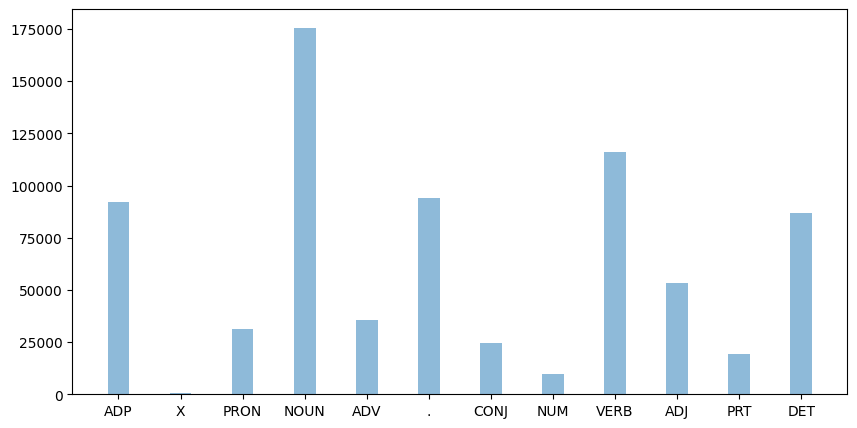

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [120]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

<ipython-input-120-747c80ba0bc0>:6: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))


Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [121]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

<ipython-input-121-0f47def21c45>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))


Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [122]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

<ipython-input-122-89f0185880b7>:2: DeprecationWarning: 
  Function evaluate() has been deprecated.  Use accuracy(gold)
  instead.
  print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))


Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [123]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [124]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [125]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [126]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
       
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)

        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)

        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)


    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_output, _ = self.lstm(embeds)
        layer_output = self.hidden2tag(lstm_output)
        return layer_output

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [127]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

_, indices = torch.max(logits, dim=2)
correct = torch.sum((indices == y_batch) & (y_batch != 0))
total = torch.sum(y_batch != 0)
acc = correct / total
# print(correct, total, acc)
print(acc)

tensor(0.0435)


In [128]:
criterion = nn.CrossEntropyLoss()
print(logits.size())
print(y_batch.size())
print(logits.reshape(-1, 13).size())
print(y_batch.reshape(-1).size())
loss = criterion(logits.reshape(-1, 13), y_batch.reshape(-1))

torch.Size([32, 4, 13])
torch.Size([32, 4])
torch.Size([128, 13])
torch.Size([128])


**Задание** Вставьте эти вычисление в функцию:

In [129]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.reshape(-1, 13), y_batch.reshape(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, indices = torch.max(logits, -1)
                # correct = torch.sum((indices == y_batch) & (y_batch != 0))
                # total = torch.sum(y_batch != 0)
                # acc = correct / total

                cur_correct_count, cur_sum_count = torch.sum((indices == y_batch) & (y_batch != 0)), torch.sum(y_batch != 0)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [130]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.31545, Accuracy = 71.62%: 100%|██████████| 572/572 [00:05<00:00, 107.68it/s]
[1 / 50]   Val: Loss = 0.10488, Accuracy = 84.99%: 100%|██████████| 13/13 [00:00<00:00, 89.88it/s]
[2 / 50] Train: Loss = 0.10055, Accuracy = 90.04%: 100%|██████████| 572/572 [00:05<00:00, 107.22it/s]
[2 / 50]   Val: Loss = 0.07311, Accuracy = 89.57%: 100%|██████████| 13/13 [00:00<00:00, 74.43it/s]
[3 / 50] Train: Loss = 0.06744, Accuracy = 93.25%: 100%|██████████| 572/572 [00:05<00:00, 100.46it/s]
[3 / 50]   Val: Loss = 0.06506, Accuracy = 91.30%: 100%|██████████| 13/13 [00:00<00:00, 84.90it/s]
[4 / 50] Train: Loss = 0.05027, Accuracy = 94.87%: 100%|██████████| 572/572 [00:05<00:00, 110.34it/s]
[4 / 50]   Val: Loss = 0.06429, Accuracy = 92.21%: 100%|██████████| 13/13 [00:00<00:00, 90.51it/s]
[5 / 50] Train: Loss = 0.04037, Accuracy = 95.89%: 100%|██████████| 572/572 [00:05<00:00, 101.74it/s]
[5 / 50]   Val: Loss = 0.06366, Accuracy = 92.67%: 100%|██████████| 13/13 [00:00<00:00, 75.83i

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [142]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())
epochs_count = 12
fit(model, criterion, optimizer, train_data=(X_test, y_test), epochs_count=epochs_count,
    batch_size=64)

[1 / 12] Train: Loss = 0.04151, Accuracy = 95.87%: 100%|██████████| 224/224 [00:02<00:00, 89.93it/s] 
[2 / 12] Train: Loss = 0.03933, Accuracy = 96.08%: 100%|██████████| 224/224 [00:02<00:00, 100.32it/s]
[3 / 12] Train: Loss = 0.03815, Accuracy = 96.25%: 100%|██████████| 224/224 [00:02<00:00, 83.94it/s]
[4 / 12] Train: Loss = 0.03710, Accuracy = 96.34%: 100%|██████████| 224/224 [00:02<00:00, 76.31it/s]
[5 / 12] Train: Loss = 0.03549, Accuracy = 96.46%: 100%|██████████| 224/224 [00:02<00:00, 97.33it/s]
[6 / 12] Train: Loss = 0.03512, Accuracy = 96.53%: 100%|██████████| 224/224 [00:02<00:00, 99.28it/s] 
[7 / 12] Train: Loss = 0.03433, Accuracy = 96.59%: 100%|██████████| 224/224 [00:02<00:00, 99.22it/s]
[8 / 12] Train: Loss = 0.03367, Accuracy = 96.65%: 100%|██████████| 224/224 [00:02<00:00, 99.84it/s]
[9 / 12] Train: Loss = 0.03297, Accuracy = 96.69%: 100%|██████████| 224/224 [00:02<00:00, 89.51it/s]
[10 / 12] Train: Loss = 0.03318, Accuracy = 96.75%: 100%|██████████| 224/224 [00:03<00:0

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

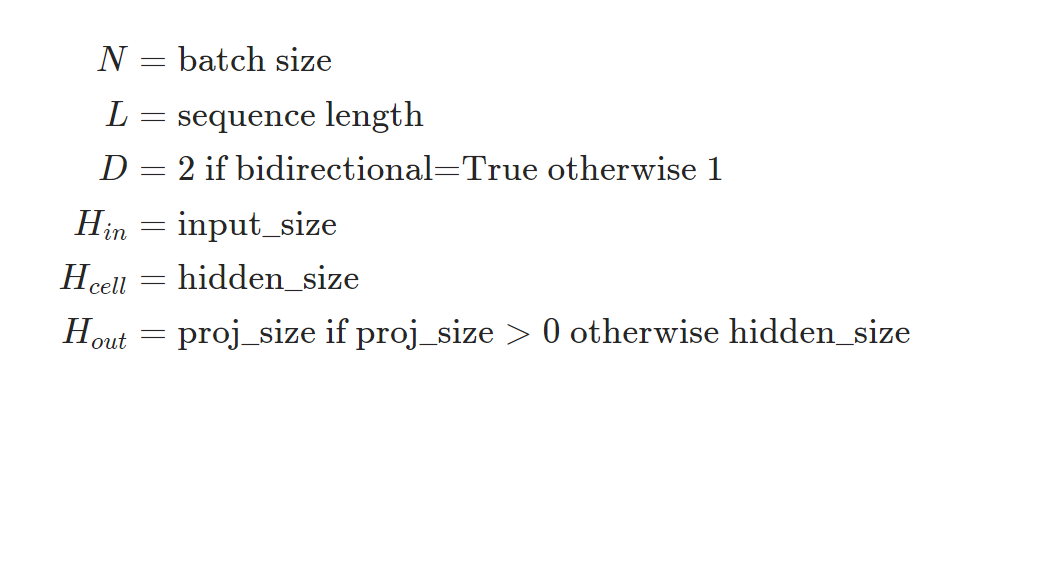

In [132]:
class BLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
       
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)

        self.blstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)

        self.hidden2tag = nn.Linear(2*lstm_hidden_dim, tagset_size)

        self.hidden = lstm_hidden_dim

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        blstm_output, _ = self.blstm(embeds)
        layer_output = self.hidden2tag(blstm_output)
        return layer_output

In [133]:
model = BLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.55567, Accuracy = 82.47%: 100%|██████████| 572/572 [00:07<00:00, 75.30it/s]
[1 / 50]   Val: Loss = 0.27365, Accuracy = 91.05%: 100%|██████████| 13/13 [00:00<00:00, 65.08it/s]
[2 / 50] Train: Loss = 0.20283, Accuracy = 93.57%: 100%|██████████| 572/572 [00:06<00:00, 86.66it/s]
[2 / 50]   Val: Loss = 0.18210, Accuracy = 94.00%: 100%|██████████| 13/13 [00:00<00:00, 62.74it/s]
[3 / 50] Train: Loss = 0.12853, Accuracy = 96.02%: 100%|██████████| 572/572 [00:07<00:00, 75.71it/s]
[3 / 50]   Val: Loss = 0.15510, Accuracy = 94.82%: 100%|██████████| 13/13 [00:00<00:00, 68.13it/s]
[4 / 50] Train: Loss = 0.08782, Accuracy = 97.32%: 100%|██████████| 572/572 [00:06<00:00, 86.55it/s]
[4 / 50]   Val: Loss = 0.13260, Accuracy = 95.62%: 100%|██████████| 13/13 [00:00<00:00, 65.25it/s]
[5 / 50] Train: Loss = 0.06092, Accuracy = 98.20%: 100%|██████████| 572/572 [00:07<00:00, 75.80it/s]
[5 / 50]   Val: Loss = 0.13008, Accuracy = 95.72%: 100%|██████████| 13/13 [00:00<00:00, 65.08it/s]


In [134]:
#test data
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

epochs_count = 12
fit(model, criterion, optimizer, train_data=(X_test, y_test), epochs_count=epochs_count)

[1 / 12] Train: Loss = 0.12399, Accuracy = 96.74%: 100%|██████████| 448/448 [00:04<00:00, 97.70it/s]
[2 / 12] Train: Loss = 0.03255, Accuracy = 97.89%: 100%|██████████| 448/448 [00:05<00:00, 81.91it/s]
[3 / 12] Train: Loss = 0.01884, Accuracy = 98.69%: 100%|██████████| 448/448 [00:04<00:00, 98.26it/s]
[4 / 12] Train: Loss = 0.01204, Accuracy = 99.16%: 100%|██████████| 448/448 [00:04<00:00, 97.57it/s]
[5 / 12] Train: Loss = 0.00762, Accuracy = 99.47%: 100%|██████████| 448/448 [00:05<00:00, 83.41it/s]
[6 / 12] Train: Loss = 0.00500, Accuracy = 99.70%: 100%|██████████| 448/448 [00:04<00:00, 97.20it/s]
[7 / 12] Train: Loss = 0.00325, Accuracy = 99.82%: 100%|██████████| 448/448 [00:04<00:00, 99.11it/s]
[8 / 12] Train: Loss = 0.00224, Accuracy = 99.89%: 100%|██████████| 448/448 [00:05<00:00, 85.82it/s]
[9 / 12] Train: Loss = 0.00153, Accuracy = 99.94%: 100%|██████████| 448/448 [00:04<00:00, 95.40it/s] 
[10 / 12] Train: Loss = 0.00110, Accuracy = 99.96%: 100%|██████████| 448/448 [00:04<00:00,

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [135]:
!pip3 -qq install gensim==3.6.0

In [ ]:
!python pip install -U gensim

python3: can't open file '/content/pip': [Errno 2] No such file or directory


In [136]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

Построим подматрицу для слов из нашей тренировочной выборки:

In [137]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [138]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
        
        self.lstm_wpte = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, lstm_layers_count, bidirectional=True)

        self.linear = nn.Linear(2*lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embedding(inputs)
        out, _ = self.lstm_wpte(embeds)
        linout = self.linear(out)
        return linout

In [139]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.57319, Accuracy = 83.38%: 100%|██████████| 572/572 [00:10<00:00, 54.44it/s]
[1 / 50]   Val: Loss = 0.25431, Accuracy = 92.44%: 100%|██████████| 13/13 [00:00<00:00, 67.34it/s]
[2 / 50] Train: Loss = 0.18563, Accuracy = 94.51%: 100%|██████████| 572/572 [00:07<00:00, 74.71it/s]
[2 / 50]   Val: Loss = 0.17269, Accuracy = 94.80%: 100%|██████████| 13/13 [00:00<00:00, 71.20it/s]
[3 / 50] Train: Loss = 0.13270, Accuracy = 96.04%: 100%|██████████| 572/572 [00:06<00:00, 90.06it/s] 
[3 / 50]   Val: Loss = 0.14147, Accuracy = 95.66%: 100%|██████████| 13/13 [00:00<00:00, 90.13it/s]
[4 / 50] Train: Loss = 0.10787, Accuracy = 96.74%: 100%|██████████| 572/572 [00:05<00:00, 101.69it/s]
[4 / 50]   Val: Loss = 0.12371, Accuracy = 96.16%: 100%|██████████| 13/13 [00:00<00:00, 89.02it/s]
[5 / 50] Train: Loss = 0.09286, Accuracy = 97.17%: 100%|██████████| 572/572 [00:06<00:00, 83.66it/s]
[5 / 50]   Val: Loss = 0.11472, Accuracy = 96.45%: 100%|██████████| 13/13 [00:00<00:00, 87.43it/s

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [140]:
#test data
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.1)

epochs_count = 12
fit(model, criterion, optimizer, train_data=(X_test, y_test), epochs_count=epochs_count)

[1 / 12] Train: Loss = 0.19266, Accuracy = 91.11%: 100%|██████████| 448/448 [00:05<00:00, 87.15it/s] 
[2 / 12] Train: Loss = 0.06509, Accuracy = 94.53%: 100%|██████████| 448/448 [00:04<00:00, 110.32it/s]
[3 / 12] Train: Loss = 0.05844, Accuracy = 95.04%: 100%|██████████| 448/448 [00:04<00:00, 111.31it/s]
[4 / 12] Train: Loss = 0.05992, Accuracy = 94.91%: 100%|██████████| 448/448 [00:05<00:00, 87.42it/s]
[5 / 12] Train: Loss = 0.06097, Accuracy = 94.86%: 100%|██████████| 448/448 [00:04<00:00, 103.63it/s]
[6 / 12] Train: Loss = 0.05848, Accuracy = 95.04%: 100%|██████████| 448/448 [00:04<00:00, 110.24it/s]
[7 / 12] Train: Loss = 0.06630, Accuracy = 94.52%: 100%|██████████| 448/448 [00:04<00:00, 98.33it/s]
[8 / 12] Train: Loss = 0.06076, Accuracy = 94.79%: 100%|██████████| 448/448 [00:04<00:00, 94.75it/s] 
[9 / 12] Train: Loss = 0.06570, Accuracy = 94.60%: 100%|██████████| 448/448 [00:04<00:00, 109.52it/s]
[10 / 12] Train: Loss = 0.06048, Accuracy = 94.85%: 100%|██████████| 448/448 [00:04<

In [141]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
fit(model, criterion, optimizer, train_data=(X_test, y_test), epochs_count=epochs_count)

[1 / 12] Train: Loss = 0.05656, Accuracy = 95.30%: 100%|██████████| 448/448 [00:03<00:00, 118.04it/s]
[2 / 12] Train: Loss = 0.05310, Accuracy = 95.49%: 100%|██████████| 448/448 [00:04<00:00, 99.85it/s]
[3 / 12] Train: Loss = 0.05330, Accuracy = 95.55%: 100%|██████████| 448/448 [00:04<00:00, 106.91it/s]
[4 / 12] Train: Loss = 0.05215, Accuracy = 95.58%: 100%|██████████| 448/448 [00:03<00:00, 118.07it/s]
[5 / 12] Train: Loss = 0.05116, Accuracy = 95.62%: 100%|██████████| 448/448 [00:03<00:00, 120.17it/s]
[6 / 12] Train: Loss = 0.05107, Accuracy = 95.63%: 100%|██████████| 448/448 [00:04<00:00, 96.25it/s]
[7 / 12] Train: Loss = 0.05116, Accuracy = 95.66%: 100%|██████████| 448/448 [00:03<00:00, 114.23it/s]
[8 / 12] Train: Loss = 0.05067, Accuracy = 95.67%: 100%|██████████| 448/448 [00:03<00:00, 117.88it/s]
[9 / 12] Train: Loss = 0.05097, Accuracy = 95.69%: 100%|██████████| 448/448 [00:03<00:00, 114.36it/s]
[10 / 12] Train: Loss = 0.05038, Accuracy = 95.71%: 100%|██████████| 448/448 [00:04<